In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/MSc Dissertation')
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/Colab Notebooks/MSc Dissertation'

In [ ]:
#@title IMPORTS

!pip install -U git+https://github.com/google/jax-cfd.git

import os
import datetime
import pickle
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Callable, Tuple, List, Union
from functools import partial
from collections import defaultdict
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import scipy.linalg as la
import matplotlib
from jax.experimental import optimizers

Array = Union[np.ndarray, jnp.ndarray]

from jax.config import config
config.update("jax_enable_x64", True)

import jax_cfd.base  as cfd
from jax_cfd.data import visualization
from jax_cfd.data import xarray_utils as xru

In [ ]:
#@title MY FUNTIONS

def energy1(traj) :
  '''~
Gives the absolute energy trajectory.
  '''
  x2 = traj[0].data**2 
  y2 = traj[1].data**2 
  e = np.sum( x2 + y2 , axis=(1,2))
  e = ( e * (Lx/Nx) * (Ly/Ny) ) / (2 * Lx * Ly)
  return e

def energy2(traj) :
  '''
Gives the relative energy difference from the lamina state of each snapshot in a trajectory.
  '''
  y_vals = np.linspace(0,2*np.pi,Ny+2)[1:-1]
  ulam = (1/(16*viscosity))*np.sin(4*y_vals)
  ulam = ulam[:,np.newaxis]
  x2 = (np.transpose(traj[0].data,axes=(0,2,1))-ulam)**2
  y2 = np.transpose(traj[1].data,axes=(0,2,1))**2
  e = np.sum( x2 + y2 , axis=(1,2))
  e = ( e * (Lx/Nx) * (Ly/Ny) ) / (2 * Lx * Ly)
  return e

def quadrant_flip(M,axes=(1,2)) :
  '''
Swaps quadrants 1 with 4 and quadrant 2 with 3 for a matrix in
axes specified.
  '''
  dims = len(M.shape)
  half_x = M.shape[axes[1]]//2
  half_y = M.shape[axes[0]]//2

  def slice_(M,axes, start1, stop1, start2, stop2):
    s = [slice(None) for i in range(M.ndim)]
    s[axes[0]] = slice(start1, stop1)
    s[axes[1]] = slice(start2, stop2)
    s = tuple(s)
    return s

  s1 = slice_(M,axes,0,half_y,0,half_x)
  s2 = slice_(M,axes,0,half_y,half_x,None)
  s3 = slice_(M,axes,half_y,None,0,half_x)
  s4 = slice_(M,axes,half_y,None,half_x,None)

  q1 = M[s1]
  q2 = M[s2]
  q3 = M[s3]
  q4 = M[s4]
  

  t = np.concatenate((q4,q3),axis=axes[1])
  b = np.concatenate((q2,q1),axis=axes[1])
  out = np.concatenate((t,b),axis=axes[0])

  return out

def Low_pass_filter(snapshot,cut_off) :
  '''
Takes in a velocity snapshot in the form of a 3D array (Ny,Nx,2), computes the 2D FFT of the array.
Terms with wavenumber that exceed cut_off value will removed and the inverse FFT will be applied to 
return a a new filtered velocity snapshot.
  '''
  (Nx,Ny,_) = snapshot.shape
  FT = np.fft.fft2(snapshot,axes=(0,1))   # Take FT of axes (2,1) to change coordinate indexing into row column indexing.
  kx = 2*np.pi*np.fft.fftfreq(Nx,(2*np.pi)/Nx)
  ky = 2*np.pi*np.fft.fftfreq(Ny,(2*np.pi)/Ny)
  kx2 = kx**2
  ky2 = ky**2
  K_grid = np.sqrt( np.tile(kx2,(Ny,1)) + np.tile(np.array([ky2]).T,(1,Nx)) )
  filtered = np.zeros((Ny,Nx,2),dtype=complex)
  count = 0

  for i in range(Nx) :      # Could make this a lot more efficient by (1) only doing for loop over square of points around zero after reordering (with side length 2*cut_off) (2) using symmetry properties.
    
    for j in range(Ny) :

      if K_grid[i,j] <= cut_off :
        count += 1
        filtered[i,j] = FT[i,j]

  return (np.real(np.fft.ifft2(filtered,axes=(0,1))),count)

def LPF(data,cut_off) :

    n_snaps = data.shape[0]

    for i in range(n_snaps) :
        (data[i] ,count) = Low_pass_filter(data[i],cut_off)

    return (data,count)

def xy_shift(snaps,x_shift,y_shift) :
  """ 
  Shift field along a continuous symmetry 
  Assumes data is periodic, uniform grid etc
  Takes an array as input with shape (n,Nx,Nx,2).
  x_shift and y_shift can either both be floats
  or both be lists/(one-dimensional arrays) of 
  length n.
  +ve x_shift is to the right
  +ve y_shift is down
  """
  Nx,Ny = snaps.shape[1:3]
  x_shift = np.array(x_shift)
  y_shift = np.array(y_shift)

  FT = np.fft.fft2(snaps,axes=(1,2))

  kx = 2*np.pi*np.fft.fftfreq(Nx,(2*np.pi)/Nx)
  ky = 2*np.pi*np.fft.fftfreq(Ny,(2*np.pi)/Ny)
  Kx,Ky = np.meshgrid(kx,ky)

  if type(x_shift) == (float or int) :
    shift_factor = np.exp(-1j*(Kx*x_shift+Ky*y_shift))
    shift_factor = np.expand_dims(shift_factor, (0,3))

  else :    # Then assume 1d array of len n
    x_shift, y_shift = x_shift[:,np.newaxis,np.newaxis], y_shift[:,np.newaxis,np.newaxis]
    Kx, Ky = Kx[np.newaxis,:], Ky[np.newaxis,:]
    shift_factor = np.exp(-1j*(Kx*x_shift+Ky*y_shift))
    shift_factor = shift_factor[:,:,:,np.newaxis]

  FT_shifted = shift_factor*FT
  shifted = np.real(np.fft.ifft2(FT_shifted,axes=(1,2)))

  return shifted

def augment(Arr) :
  '''
Augment data of shape (n,256,256,2) into shape
(4n,256,256,2) where the extra entries arise from shifting in y by pi/2
,pi and 3pi/2 (with random, continuous x-shift applied after ).
  '''
  n = Arr.shape[0]
  y_shifts = (np.pi/2)*np.ones(n)
  x_shifts = np.random.uniform(0,2*np.pi,n)
  augmented = xy_shift(np.copy(Arr),x_shifts,np.zeros(n)) # Shift first n snapshots in x randomly (not in y)

  for i in range(1,4) :
    x_shifts = np.random.uniform(0,2*np.pi,n)
    add = xy_shift(Arr,x_shifts,i*y_shifts)
    augmented = np.concatenate((augmented,add),axis=0)
  
  return augmented

def vis(snapshot,minmax=10) :
  ''' 
  visualise the vorticity field of a snapshot
  with dimension (Ny,Nx,2)
  '''
  (Nx,Ny,_) = snapshot.shape

  fig, axs = plt.subplots(1,figsize=(10,8))
  axs.set_xlabel('x',fontsize=20)
  axs.set_ylabel('y',fontsize=20)
  snapshot_T = snapshot.T
  xarray = xru.velocity_trajectory_to_xarray(
  tuple([snapshot_T[0:1,:,:],snapshot_T[1:2,:,:]]),
  grid)
  vort = xarray.pipe(vorticity).data.T

  im = axs.imshow(vort[:,:,0], cmap=sns.cm.icefire,vmin=-minmax, vmax=minmax,extent=[0,2*np.pi,0,2*np.pi],origin='lower')

  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.12, 0.03, 0.77])
  fig.colorbar(im, cax=cbar_ax)#,label='Vorticity')
  cbar_ax.get_yaxis().labelpad = 27
  cbar_ax.set_ylabel('Vorticity', rotation=270,fontsize=20)

  return fig,axs

def Vis_before_and_after(snapshot,cut_off) :
  '''
  Takes a (Ny,Nx,2) shaped velocity snapshot array and returns a visualisation 
  of the vorticity before and after the application of a low-pass filter.
  The low-pass filter cuts off wavenumbers where |k| > cut_off.
  '''
  (Nx,Ny,_) = snapshot.shape

  # Initial vorticity visualisation :
  fig, axs = plt.subplots(1,2,figsize=(15,6.5))

  snapshot_T = snapshot.T
  xarray = xru.velocity_trajectory_to_xarray(
  tuple([snapshot_T[0:1,:,:],snapshot_T[1:2,:,:]]),
  grid)
  vort = xarray.pipe(vorticity).data.T

  axs[0].imshow(vort[:,:,0], cmap=sns.cm.icefire,vmin=-10, vmax=10,extent=[0,2*np.pi,0,2*np.pi],origin='lower')
  axs[0].set_title('Before filterisation',fontsize=24,y=1.03)
  axs[0].xaxis.labelpad = 18
  axs[0].tick_params(axis='both', which='major', labelsize=16)
  axs[0].set_xlabel(r"$x$",fontsize=25)
  axs[0].set_ylabel(r"$y$",fontsize=25)
  axs[0].yaxis.labelpad = 34

  # Put snapshot through Low-pass filter :
  after = Low_pass_filter(snapshot,cut_off)[0]
  after_T = after.T

  # Visualise filtered vorticity :
  xarray = xru.velocity_trajectory_to_xarray(
  tuple([after_T[0:1,:,:],after_T[1:2,:,:]]),
  grid)
  vort = xarray.pipe(vorticity).data.T

  im = axs[1].imshow(vort[:,:,0], cmap=sns.cm.icefire,vmin=-10, vmax=10,extent=[0,2*np.pi,0,2*np.pi],origin='lower')
  axs[1].set_title('After filterisation',fontsize=24,y=1.03)
  axs[1].xaxis.labelpad = 18
  axs[1].tick_params(axis='both', which='major', labelsize=16)
  axs[1].set_xlabel(r"$x$",fontsize=25)

  # Get colourbar
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.84, 0.14, 0.03, 0.71])
  fig.colorbar(im, cax=cbar_ax)
  cbar_ax.get_yaxis().labelpad = 34
  cbar_ax.set_ylabel('Vorticity', rotation=270,fontsize=25)
  cbar_ax.tick_params(axis='both', which='major', labelsize=16)


  return fig,axs

def read_log(filename):
  
  fileObj = open(filename, "r")
  S = fileObj.read()
  fileObj.close()
  S = S.replace("   ", " ").replace("  "," ")

  train_val_test = []

  for i in range(2) :
    start_list_1 = S.index('[')
    end_list_1 = S.index(']')
    dummy = S[start_list_1+1:end_list_1]
    dummy = dummy.replace('\n','')
    dummy = dummy.split(' ')
    d_len = len(dummy)
    for i in range(d_len) :
      if dummy[i] == "" :
        dummy.pop(i)
    dummy = list(map(float, dummy))
    train_val_test.append(dummy)
    S = S[end_list_1+1:]

  test_rmse_index = S.index('=') + 2
  test_rmse = S[test_rmse_index:test_rmse_index+5].replace('\\','').replace('n','')
  train_val_test.append(float(test_rmse))

  return train_val_test

In [ ]:
#@title JACOB'S FUNCTIONS


def jnp_to_gv_tuple(u_jnp: Array, offsets: List[Tuple], 
                    grid: cfd.grids.Grid, bc: cfd.grids.BoundaryConditions) -> Tuple[cfd.grids.GridVariable]:
    gv_list = []
    for i in range(u_jnp.shape[-1]):
        garr = cfd.grids.GridArray(u_jnp[..., i], offsets[i], grid)
        gv_list.append(cfd.grids.GridVariable(garr, bc))
    return tuple(gv_list)

def gv_tuple_to_jnp(gv_tuple: Tuple[cfd.grids.GridVariable]) -> Tuple[Array, List[Tuple]]:
    u_jnp = jnp.stack([gv.data for gv in gv_tuple], axis=-1)
    offsets = [gv.offset for gv in gv_tuple]
    return u_jnp, offsets

def generate_time_forward_map(viscosity: float, T: float) -> Callable[[Tuple[cfd.grids.GridVariable]], Tuple[cfd.grids.GridVariable]]:
    N_steps = jnp.floor(T / dt_stable)
    dt_exact = T / N_steps

    def convect(v): 
        return tuple(cfd.advection.advect_linear(u, v, dt_exact) for u in v)

    time_forward_map = cfd.funcutils.repeated(
        cfd.equations.semi_implicit_navier_stokes(
            density=density, viscosity=viscosity, dt=dt_exact, grid=grid, forcing=kolmogorov, convect=convect),
        steps=N_steps)
    return jax.jit(time_forward_map)

def apply_forward_map_T(u_initial: Tuple[cfd.grids.GridVariable], 
                        T: float, t_substep=.1) -> Tuple[cfd.grids.GridVariable]:
    """ Advance solution forward T by repeated application a forward map over t_substep """ 
    N_substeps = jnp.floor(T / t_substep)
    t_remains = T - (N_substeps - 1) * t_substep # make sure we always have > one substep remaining

    map_substep = generate_time_forward_map(viscosity, t_substep)
    map_bulk = jax.jit(cfd.funcutils.repeated(jax.remat(map_substep), steps=N_substeps-1))
    u_bulk = map_bulk(u_initial)
    map_remain = generate_time_forward_map(viscosity, t_remains)
    u_final = map_remain(u_bulk)
    return u_final  


def generate_trajectory_fn(viscosity: float, T: float):
  """ Note approximate T here, this is for RFA. dt_snap = 1 [needs updating] """  
  N_steps_total = jnp.floor(T / dt_stable) #T // dt_stable
  dt_exact = T / N_steps_total

  N_steps_per_substep = jnp.floor(1. / dt_exact)
  N_substeps = N_steps_total // N_steps_per_substep

  def convect(v): 
    return tuple(cfd.advection.advect_linear(u, v, dt_exact) for u in v)

  step_fn = cfd.funcutils.repeated(
      cfd.equations.semi_implicit_navier_stokes(
          density=density, viscosity=viscosity, dt=dt_exact, grid=grid, forcing=kolmogorov, convect=convect),
          steps=N_steps_per_substep)
  
  trajectory_fn = jax.jit(cfd.funcutils.trajectory(jax.remat(step_fn), N_substeps)) 
  return trajectory_fn

def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')


# FOURIER PLOTS

In [1]:
#@title Generate and store trajectory of length T for specified Re 

Nx = 256
Ny = 256
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi

density = 1.
n_waves = 4 # number of forcing wavelengths
grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))
max_velocity = 5.0
kolmogorov = cfd.forcings.kolmogorov_forcing(grid, k=n_waves)


trajs = []
Re = (30,55,80)
T = 200
burnin = 100

for i in Re :
  viscosity = 1/i
  dt_stable = cfd.equations.stable_time_step(max_velocity, 0.5, viscosity, grid) / 2. # should take care here
  seed = np.random.randint(0,1000)
  v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(seed), grid, 5.)


  rollout_fn = jax.jit(generate_trajectory_fn(viscosity, T))
  %time _, trajectory = jax.device_get(rollout_fn(v0))

  u = np.transpose(trajectory[0].data,axes=(0,2,1))[burnin:]          # Take transpose to give correct indexing for u and v
  v = np.transpose(trajectory[1].data,axes=(0,2,1))[burnin:]

  trajs.append([u,v])

NameError: ignored

In [ ]:
#@title 2d Fourier spectra at Re = (...) 


fig, ax= plt.subplots(1,3,figsize=(20,5.5))
plt.suptitle(f'Energy spectra - 2D',fontsize=30, y=1.04)
ax[0].set_ylabel(r"$K_{y}$",fontsize=20)
ax[0].yaxis.labelpad = 5

e_means = []

for i in range(3) :
  u = trajs[i][0]
  v = trajs[i][1]

  FT_u = (1/(Nx*Ny))*quadrant_flip(np.fft.fft2(u, axes=(1,2)),axes=(1,2))
  FT_v = (1/(Nx*Ny))*quadrant_flip(np.fft.fft2(v, axes=(1,2)),axes=(1,2))
  e_kx_ky = (np.abs(FT_u)**2 + np.abs(FT_v)**2)/2
  e_mean = np.mean(e_kx_ky,axis=0)
  e_means.append(e_mean)
  im = ax[i].imshow(np.log(e_means[i]),origin='lower',extent=[-127,128,-127,128]) # ,vmin=0,vmax=0.00001
  ax[i].set_xlabel(r"$K_{x}$",fontsize=20)
  ax[i].set_title(f'Re = {Re[i]}',fontsize=28)
  ax[i].xaxis.labelpad = 18
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.835, 0.14, 0.03, 0.715])
fig.colorbar(im,cax=cbar_ax)
cbar_ax.get_yaxis().labelpad = 33
cbar_ax.set_ylabel(r'$log ( \hat{e} )$', rotation=270,fontsize=20)

#plt.savefig('2d_spectra.svg', format='svg', bbox_inches='tight')

In [ ]:
#@title 1d Fourier spectra


fig, ax= plt.subplots(1,figsize=(10,10))
ax.set_title(f'Energy spectra - 1D',fontsize=30,y=1.04)
ax.set_ylabel(r'$D(n)$',fontsize=20)
ax.set_xlabel(r'$n$',fontsize=20)
ax.yaxis.labelpad = 18
ax.xaxis.labelpad = 18
ax.set(yscale="log")
ax.set(ylim=(1e-28, 100))
ax.set(xlim=(-5, 150))

def default_value():
    return 0
def zero() :
  return 0 

# Forming an array of wavenumber magnitudes to correspond to the FT_u and FT_v arrays.
kx = 2*np.pi*np.fft.fftfreq(Nx,Lx/Nx)
ky = 2*np.pi*np.fft.fftfreq(Ny,Ly/Ny)
# Reordering kx into ascending wavenumber order.
kx = np.concatenate((kx[Nx//2:],kx[0:Nx//2]))
ky = np.concatenate((ky[Ny//2:],ky[0:Ny//2]))
kx2 = kx**2
ky2 = ky**2
K_grid = np.sqrt( np.tile(kx2,(Ny,1)) + np.tile(np.array([ky2]).T,(1,Nx)) )
K_grid_rounded = K_grid.round().astype(int)   # This is used to match with CK13 graphic.
K_grid_sqd = np.power(K_grid,2).astype(int)

# In dictionary K_coeffs the keys are the wavenumber magnitudes squared and 
# the values are the FT coefficient 'energies'



for k in range(len(trajs)) :
  energy_dict = defaultdict(default_value)
  e_kx_ky = e_means[k]
  for i in range(Ny):
    energy_dict[K_grid_rounded[i,0]] += e_kx_ky[i,0]    # First column does not match with a -k, so is not doubled.

    for j in range(1,Nx//2+1):                        
      energy_dict[K_grid_rounded[i,j]] += 2*e_kx_ky[i,j]    # Using symmetry E(-k)=E(k) so all these values are doubled.

  energy_dict[K_grid_rounded[Ny//2,Nx//2]] = energy_dict[K_grid_rounded[Nx//2,Ny//2]]/2    # These values were double counted. ( (0,128) , (128,128) )
  energy_dict[K_grid_rounded[0,Ny//2]] = energy_dict[K_grid_rounded[0,Ny//2]]/2

  # Extracting data from the Wavenumber dictionary.
  # Coefficient values get placed into an array where each row is the spectrum for
  # a time step (ascending order in time) 

  wavenumbers = list(energy_dict.keys())
  coeffs=list(energy_dict.values())
  ax = sns.scatterplot(wavenumbers,coeffs,label=f'Re = {Re[k]}')
plt.legend(fontsize=20)

#plt.savefig('1d_spectra.svg', format='svg', bbox_inches='tight')

#RESULTS PLOTS

In [ ]:
LR = 1
Data = 3
Model = 1

In [ ]:
#@title Training, validation, testing plot

train,val,test = read_log(f"Model_logs/LR_{LR}/log_D{Data}_M{Model}.txt")

blue = sns.color_palette('muted')[0]
green = sns.color_palette('muted')[2]
red = sns.color_palette('muted')[3]

fig, ax = plt.subplots(1,figsize=(16,10))
w = 4
epochs = len(train)

sns.lineplot(x=list(range(epochs)),y=train,ax=ax,label="training",linewidth=w,color=blue)
sns.lineplot(x=list(range(epochs)),y=val,ax=ax,label="validation",linewidth=w,color=green)
ax.axhline(test,label='testing',color=red,linewidth=w).set_linestyle("--")


# Styling :
# ax.set_title(f'Energy spectra - 1D',fontsize=30,y=1.04)
ax.set_ylabel('RMSE',fontsize=30)
ax.set_xlabel("Epoch",fontsize=30)
ax.yaxis.labelpad = 18
ax.xaxis.labelpad = 18
#ax.set(ylim=(0,5))
ax.set(xlim=(0, 200))
ax.tick_params(labelsize=20)
plt.legend(fontsize=30)


# plt.savefig('Train_val_test_LR3_D3_M3.svg', format='svg', bbox_inches='tight')

In [ ]:
#@title Comparing Learning rates

train,val,test = read_log(f"Model_logs/LR_{1}/log_D{Data}_M{Model}.txt")
train2,val,test = read_log(f"Model_logs/LR_{2}/log_D{Data}_M{Model}.txt")

blue = sns.color_palette('bright')[0]
lblue = sns.color_palette('muted')[9]
red = sns.color_palette('muted')[3]

fig, ax = plt.subplots(1,figsize=(16,10))
w = 4
epochs = len(train)

sns.lineplot(x=list(range(epochs)),y=train,ax=ax,label=r"$\alpha=1\times10^{-3}$",linewidth=w,color=blue)
sns.lineplot(x=list(range(epochs)),y=train2,ax=ax,label=r"$\alpha=4\times10^{-3}$",linewidth=w,color=lblue)

# Styling :
# ax.set_title(f'Energy spectra - 1D',fontsize=30,y=1.04)
ax.set_ylabel('RMSE',fontsize=30)
ax.set_xlabel("Epoch",fontsize=30)
ax.yaxis.labelpad = 18
ax.xaxis.labelpad = 18
#ax.set(ylim=(0,5))
ax.set(xlim=(0, 200))
ax.tick_params(labelsize=20)
plt.legend(fontsize=30)

# plt.savefig('Learning_rates_D3_M1.svg', format='svg', bbox_inches='tight')

In [ ]:
#@title Training data spread


file = open('y_train_test_20_13.pickle','rb')
(y_train1,y_test1) = pickle.load( file )
file.close()

file = open('y_train_test_20_15.pickle','rb')
(y_train2,y_test2) = pickle.load( file )
file.close()

file = open('y_train_test_30_12.pickle','rb')
(y_train3,y_test3) = pickle.load( file )
file.close()

y_train = np.concatenate((y_train1,y_train2,y_train3))
y_test = np.concatenate((y_test1,y_test2,y_test3))

fig, ax = plt.subplots(1,2,figsize = (20,5))

sns.histplot(y_train,bins=20,ax=ax[0])
sns.histplot(y_test,bins=20,ax=ax[1])

# TESTING PLOTS

In [ ]:
#@title Import predictions data (LR3_D3_M3) and set up  

file = open( 'Data/predictions.pickle', 'rb' )
(predictions,y_test) = pickle.load( file )

n = len(predictions)

diff = predictions - y_test

In [ ]:
np.sqrt(np.sum((predictions-y_test)**2)/n)

2.4056120885362478

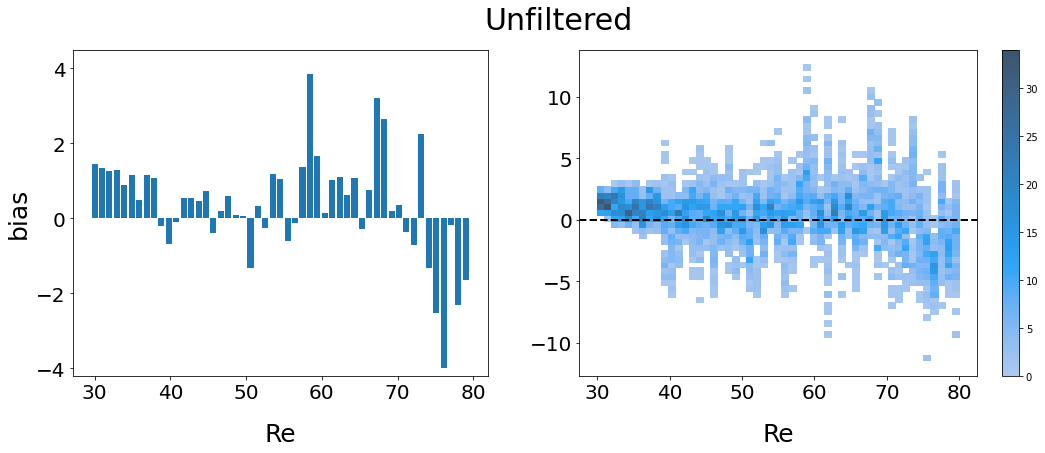

In [ ]:
#@title All errors histogram

fig, axis = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [1,1.2]})
plt.suptitle('Unfiltered',fontsize=30)

bin_w = 1
bins = int(50/bin_w) +1
bias = np.zeros(bins)
count = np.zeros(bins)

for i in range(n) :
  bin = int( (y_test[i] - 29.99)//bin_w )
  bias[bin] += diff[i]
  count[bin] += 1

bias = bias/count

Range = (50*(np.array((range(bins)))/bins))+30

axis[0].bar(Range,bias)
axis[0].set(ylim=(-4.2,4.5))



sns.histplot(x=y_test,y=diff,bins=51,cbar=True,ax=axis[1])

axis[1].axhline(0,color='black',linewidth=2).set_linestyle("--")

axis[0].set_ylabel("bias",fontsize=25)
axis[1].set_xlabel("Re",fontsize=25)
axis[0].set_xlabel("Re",fontsize=25)
axis[0].yaxis.labelpad = 5
axis[1].xaxis.labelpad = 20
axis[0].xaxis.labelpad = 20
axis[0].tick_params(labelsize=20)
axis[1].tick_params(labelsize=20)

fig.savefig('pred_bias.svg', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


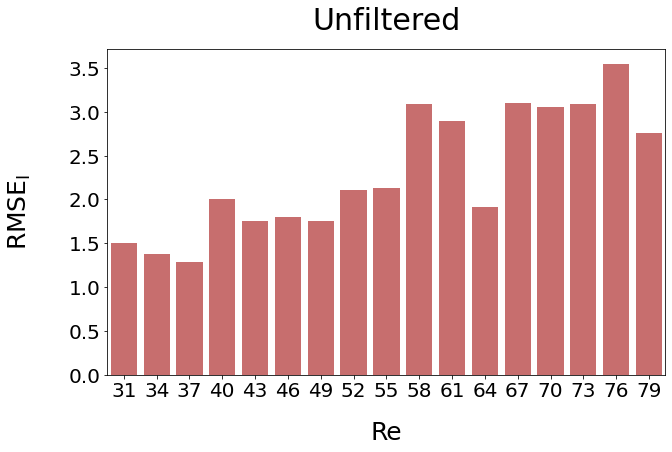

In [ ]:
#@title RMSE (of each bin) histogram

fig, axis = plt.subplots(1,1,figsize=(10,6))
axis.set_title('Unfiltered',fontsize=30,y=1.04)
red = sns.color_palette('muted')[3]

se = (diff**2)
bin_w = 3
bins = int(51/bin_w)
sum_se = np.zeros(bins)
count = np.zeros(bins)

for i in range(n) :
  bin = int( (y_test[i] - 30)//bin_w )
  sum_se[bin] += se[i]
  count[bin] += 1



mse = sum_se/count
rmse = np.sqrt(mse)

Range = ((51*(np.array((range(bins)))/bins))+31).astype(int)

sns.barplot(Range,rmse,color=red,ax=axis)


axis.set_ylabel(r"$\mathrm{RMSE}_{\mathrm{I}}$",fontsize=25)
axis.set_xlabel(r"Re",fontsize=25)
axis.yaxis.labelpad = 35
axis.xaxis.labelpad = 20
axis.tick_params(labelsize=20)

fig.savefig('pred_rmse.svg', bbox_inches='tight')

# LOW PASS FILTER PLOTS

In [ ]:
#@title Generate and store trajectory of length T for specified Re 

Nx = 256
Ny = 256
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi

density = 1.
n_waves = 4 # number of forcing wavelengths
grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))
max_velocity = 5.0
kolmogorov = cfd.forcings.kolmogorov_forcing(grid, k=n_waves)


Re = 50
T = 200
burnin = 100

viscosity = 1/Re
dt_stable = cfd.equations.stable_time_step(max_velocity, 0.5, viscosity, grid) / 2. # should take care here
seed = np.random.randint(0,1000)
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(seed), grid, 5.)


rollout_fn = jax.jit(generate_trajectory_fn(viscosity, T))
%time _, trajectory = jax.device_get(rollout_fn(v0))

u = np.transpose(trajectory[0].data,axes=(0,2,1))[burnin:]          # Take transpose to give correct indexing for u and v
v = np.transpose(trajectory[1].data,axes=(0,2,1))[burnin:]

traj = ([u,v])

CPU times: user 11min 4s, sys: 35.3 s, total: 11min 40s
Wall time: 8min 24s


In [ ]:
#@title Before and after filter

t = 60
cut_off = 5

u = traj[0][t]
v = traj[1][t]

snapshot = np.concatenate((u[:,:,np.newaxis],v[:,:,np.newaxis]),axis=2)
print(snapshot.shape)

Vis_before_and_after(snapshot,cut_off)

plt.savefig('filterisation_5.svg', format='svg', bbox_inches='tight')

In [ ]:
#@title 2d Fourier spectra before and after filter

cut_off = 50

fig, ax= plt.subplots(1,2,figsize=(14,5.5))

ax[0].set_ylabel(r"$K_{y}$",fontsize=25)
ax[0].yaxis.labelpad = 5

t = 99

u = traj[0][t:t+1]
v = traj[1][t:t+1]

FT_u = (1/(Nx*Ny))*quadrant_flip(np.fft.fft2(u, axes=(1,2)),axes=(1,2))
FT_v = (1/(Nx*Ny))*quadrant_flip(np.fft.fft2(v, axes=(1,2)),axes=(1,2))
e_kx_ky = (np.abs(FT_u)**2 + np.abs(FT_v)**2)/2

im = ax[0].imshow(np.log(e_kx_ky[0]),origin='lower',extent=[-127,128,-127,128]) # ,vmin=0,vmax=0.00001
ax[0].set_xlabel(r"$K_{x}$",fontsize=25)
ax[0].xaxis.labelpad = 18
ax[0].tick_params(axis='both', which='major', labelsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.835, 0.125, 0.03, 0.75])
fig.colorbar(im,cax=cbar_ax)
cbar_ax.get_yaxis().labelpad = 45
cbar_ax.set_ylabel(r'$log ( \hat{E} )$', rotation=270,fontsize=25)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)
# Low pass filter and plot again

u_ = u[0,:,:,np.newaxis]
v_ = v[0,:,:,np.newaxis]
snap = np.concatenate((u_,v_),axis=2)
snap.shape
lpf = Low_pass_filter(snap,cut_off)

u_ = lpf[np.newaxis,:,:,0]
v_ = lpf[np.newaxis,:,:,1]

FT_u_ = (1/(Nx*Ny))*quadrant_flip(np.fft.fft2(u_, axes=(1,2)),axes=(1,2))
FT_v_ = (1/(Nx*Ny))*quadrant_flip(np.fft.fft2(v_, axes=(1,2)),axes=(1,2))
e_kx_ky_ = (np.abs(FT_u_)**2 + np.abs(FT_v_)**2)/2

ax[1].imshow(np.log(e_kx_ky_[0]),origin='lower',extent=[-127,128,-127,128]) # ,vmin=0,vmax=0.00001
ax[1].set_xlabel(r"$K_{x}$",fontsize=25)
ax[1].xaxis.labelpad = 18
ax[1].tick_params(axis='both', which='major', labelsize=15)

plt.savefig('2d_spectrum_filtered.svg', format='svg', bbox_inches='tight')

In [ ]:

#@title 1d Fourier spectra before and after filter

fig, ax= plt.subplots(1,2,figsize=(16,6.5))
ax[0].set_ylabel(r'$D(n)$',fontsize=20)
ax[0].set_xlabel(r'$n$',fontsize=20)
ax[1].set_xlabel(r'$n$',fontsize=20)
ax[0].yaxis.labelpad = 18
ax[0].xaxis.labelpad = 18
ax[1].xaxis.labelpad = 18
ax[0].set(yscale="log")
ax[1].set(yscale="log")
ax[0].set(ylim=(1e-28, 100))
ax[1].set(ylim=(1e-28, 100))
ax[0].set(xlim=(-5, 150))
ax[1].set(xlim=(-5, 150))

def default_value():
    return 0

# Forming an array of wavenumber magnitudes to correspond to the FT_u and FT_v arrays.
kx = 2*np.pi*np.fft.fftfreq(Nx,Lx/Nx)
ky = 2*np.pi*np.fft.fftfreq(Ny,Ly/Ny)
# Reordering kx into ascending wavenumber order.
kx = np.concatenate((kx[Nx//2:],kx[0:Nx//2]))
ky = np.concatenate((ky[Ny//2:],ky[0:Ny//2]))
kx2 = kx**2
ky2 = ky**2
K_grid = np.sqrt( np.tile(kx2,(Ny,1)) + np.tile(np.array([ky2]).T,(1,Nx)) )
K_grid_rounded = K_grid.round().astype(int)   # This is used to match with CK13 graphic.
K_grid_sqd = np.power(K_grid,2).astype(int)

# In dictionary K_coeffs the keys are the wavenumber magnitudes squared and 
# the values are the FT coefficient 'energies'


energy_dict = defaultdict(default_value)

for i in range(Ny):
  energy_dict[K_grid_rounded[i,0]] += e_kx_ky[0,i,0]    # First column does not match with a -k, so is not doubled.

  for j in range(1,Nx//2+1):                        
    energy_dict[K_grid_rounded[i,j]] += 2*e_kx_ky[0,i,j]    # Using symmetry E(-k)=E(k) so all these values are doubled.

energy_dict[K_grid_rounded[Ny//2,Nx//2]] = energy_dict[K_grid_rounded[Nx//2,Ny//2]]/2    # These values were double counted. ( (0,128) , (128,128) )
energy_dict[K_grid_rounded[0,Ny//2]] = energy_dict[K_grid_rounded[0,Ny//2]]/2

wavenumbers = list(energy_dict.keys())
coeffs=list(energy_dict.values())
sns.scatterplot(wavenumbers,coeffs,label=f'Re = {Re}',ax=ax[0])


# For filtered snapshot

energy_dict = defaultdict(default_value)

for i in range(Ny):
  energy_dict[K_grid_rounded[i,0]] += e_kx_ky_[0,i,0]    # First column does not match with a -k, so is not doubled.

  for j in range(1,Nx//2+1):                        
    energy_dict[K_grid_rounded[i,j]] += 2*e_kx_ky_[0,i,j]    # Using symmetry E(-k)=E(k) so all these values are doubled.

energy_dict[K_grid_rounded[Ny//2,Nx//2]] = energy_dict[K_grid_rounded[Nx//2,Ny//2]]/2    # These values were double counted. ( (0,128) , (128,128) )
energy_dict[K_grid_rounded[0,Ny//2]] = energy_dict[K_grid_rounded[0,Ny//2]]/2

wavenumbers = list(energy_dict.keys())
coeffs=list(energy_dict.values())
sns.scatterplot(wavenumbers,coeffs,label=f'Re = {Re}',ax=ax[1])

#plt.savefig('1d_spectra.svg', format='svg', bbox_inches='tight')

# POST FILTERING TESTING PLOTS

In [ ]:
#@title Cutoff vs RMSE

cut_offs = [1,1.6,2,2.6,3,3.4,4,5,6,7,8,9,10,15,20]
rmses = []
for c in cut_offs :
  file = open( f'Data/LPF predictions/predictions_LPF_{c}.pickle', 'rb')
  (predictions,y_test) = pickle.load( file )
  file.close()

  n = len(predictions)
  rmses.append(np.sqrt(np.sum((predictions-y_test)**2)/n))



fig,axis = plt.subplots(1,figsize=(10,7))
axis.plot(cut_offs,rmses,marker=".",markerfacecolor='black', markersize=16,linewidth=3)
axis.axhline(2.405,color='grey',linewidth=2).set_linestyle("--")

axis.set(xlim=(0,17))
axis.set(ylim=(0,11))
axis.set_ylabel(r"RMSE",fontsize=25)
axis.set_xlabel(r"Filter cut-off",fontsize=25)
axis.yaxis.labelpad = 35
axis.xaxis.labelpad = 20
axis.tick_params(labelsize=20)

fig.savefig('cutoff_rmse.svg', bbox_inches='tight')

In [ ]:
#@title Import predictions data (LR3_D3_M3) and set up  

cut_off = 2

file = open( f'Data/LPF predictions/predictions_LPF_{cut_off}.pickle', 'rb' )
(predictions,y_test) = pickle.load( file )
file.close()

n = len(predictions)

diff = predictions - y_test
translation = 0

print("RMSE = ",np.sqrt(np.sum((predictions+translation-y_test)**2)/n))

RMSE =  5.126061064987165


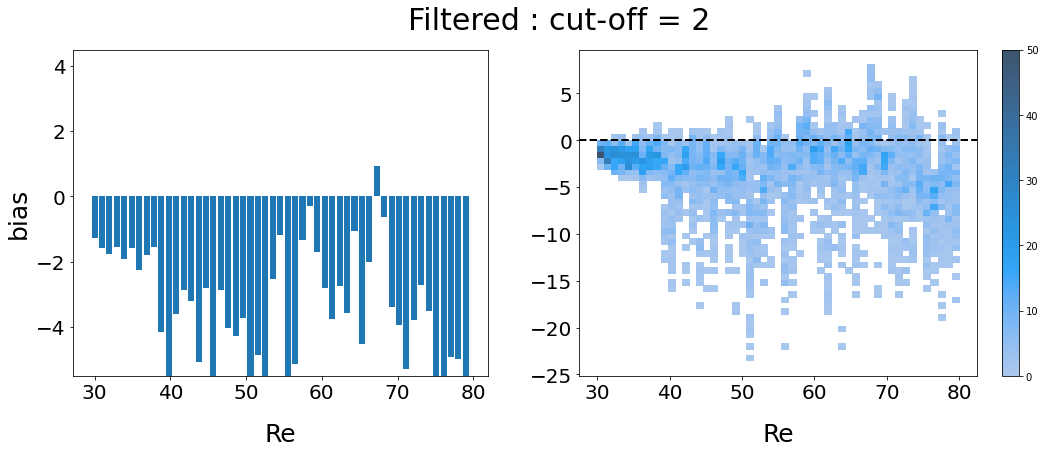

In [ ]:
#@title All errors histogram

fig, axis = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [1,1.2]})
plt.suptitle(f'Filtered : cut-off = {cut_off}',fontsize=30)

bin_w = 1
bins = int(50/bin_w) +1
bias = np.zeros(bins)
count = np.zeros(bins)

for i in range(n) :
  bin = int( (y_test[i] - 29.99)//bin_w )
  bias[bin] += diff[i]
  count[bin] += 1

bias = bias/count

Range = (50*(np.array((range(bins)))/bins))+30

axis[0].bar(Range,bias)
axis[0].set(ylim=(-5.5,4.5))



sns.histplot(x=y_test,y=diff,bins=51,cbar=True,ax=axis[1])

axis[1].axhline(0,color='black',linewidth=2).set_linestyle("--")

axis[0].set_ylabel(r'bias',fontsize=25)
axis[1].set_xlabel("Re",fontsize=25)
axis[0].set_xlabel("Re",fontsize=25)
axis[0].yaxis.labelpad = 5
axis[1].xaxis.labelpad = 20
axis[0].xaxis.labelpad = 20
axis[0].tick_params(labelsize=20)
axis[1].tick_params(labelsize=20)

fig.savefig('pred_bias_co3.svg', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


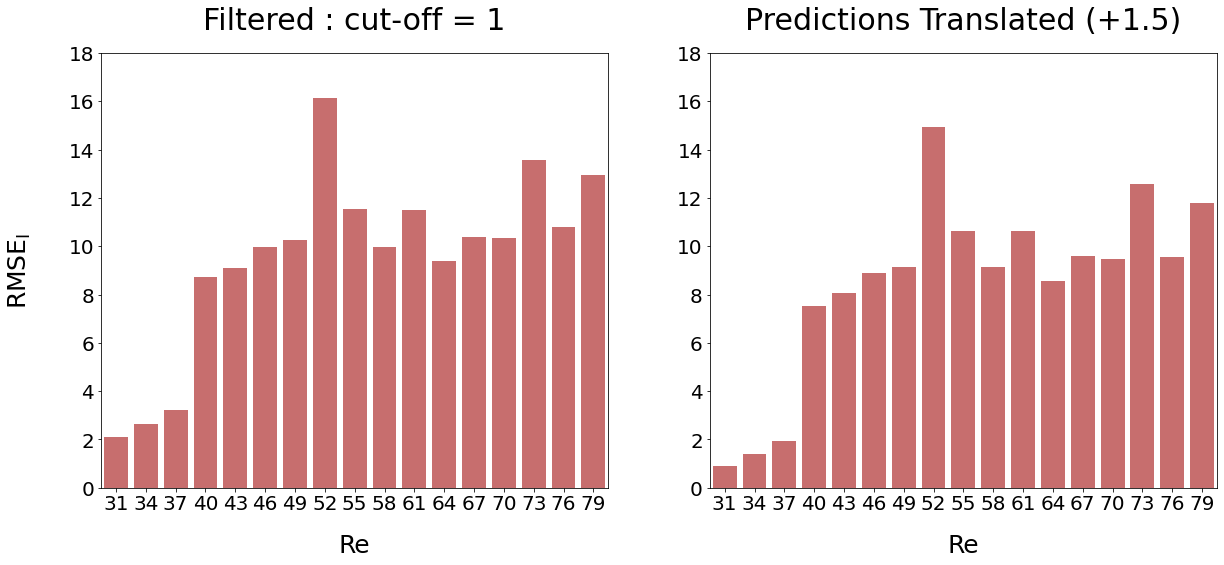

In [ ]:
#@title RMSE (of each bin) histogram

fig, axis = plt.subplots(1,2,figsize=(20,8))
axis[0].set_title(f'Filtered : cut-off = {cut_off}',fontsize=30,y=1.04)
red = sns.color_palette('muted')[3]

se = ((diff)**2)
bin_w = 3
bins = int(51/bin_w)
sum_se = np.zeros(bins)
count = np.zeros(bins)

for i in range(n) :
  bin = int( (y_test[i] - 30)//bin_w )
  sum_se[bin] += se[i]
  count[bin] += 1

mse = sum_se/count
rmse = np.sqrt(mse)

Range = ((51*(np.array((range(bins)))/bins))+31).astype(int)

axis[1].set_title(f'Predictions Translated (+1.5)',fontsize=30,y=1.04)

se1 = ((diff+1.5)**2)
bin_w = 3
bins = int(51/bin_w)
sum_se1 = np.zeros(bins)
count1 = np.zeros(bins)

for i in range(n) :
  bin = int( (y_test[i] - 30)//bin_w )
  sum_se1[bin] += se1[i]
  count1[bin] += 1

mse1 = sum_se1/count
rmse1 = np.sqrt(mse1)


sns.barplot(Range,rmse,color=red,ax=axis[0])
sns.barplot(Range,rmse1,color=red,ax=axis[1])

axis[0].set_ylabel(r"$\mathrm{RMSE}_{\mathrm{I}}$",fontsize=25)
axis[0].set_xlabel(r"Re",fontsize=25)
axis[1].set_xlabel(r"Re",fontsize=25)
axis[0].yaxis.labelpad = 35
axis[0].xaxis.labelpad = 20
axis[1].xaxis.labelpad = 20
axis[0].tick_params(labelsize=20)
axis[1].tick_params(labelsize=20)

axis[0].set(ylim=(0,18))
axis[1].set(ylim=(0,18))

fig.savefig('pred_rmse_co3.svg', bbox_inches='tight')

In [ ]:
#@title The number of terms at a given cut-off.

cut_off = 500

Nx,Ny = 256,256
kx = 2*np.pi*np.fft.fftfreq(Nx,(2*np.pi)/Nx)
ky = 2*np.pi*np.fft.fftfreq(Ny,(2*np.pi)/Ny)
kx2 = kx**2
ky2 = ky**2
K_grid = np.sqrt( np.tile(kx2,(Ny,1)) + np.tile(np.array([ky2]).T,(1,Nx)) )
count = 0

for i in range(Nx) :      # Could make this a lot more efficient by (1) only doing for loop over square of points around zero after reordering (with side length 2*cut_off) (2) using symmetry properties.
  
  for j in range(Ny) :

    if K_grid[i,j] <= cut_off :
      count += 1

print(count)

65536
